모두를 위한 머신러닝 _ Back2Basic
============

03. Convolution Neural Networks
-------------------------

---

### 순서

1. Convolution의 기본 구조
2. 좀더 깊에 학습시켜보자
3. 코드를 간단하게 만들자. + class
4. 앙상블(ensemble)


---

## [1. Convolution의 기본 구조](https://youtu.be/Em63mknbtWo)

In [1]:
# Lab 11 MNIST and Convolutional Neural Network
import tensorflow as tf
import random
# import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [3]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

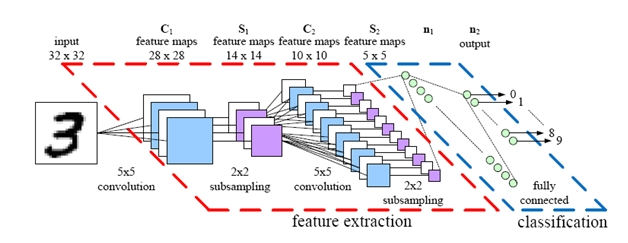

In [24]:
from IPython.display import Image
Image('images/CNNArchitecture.png')

### image(28 x 28)
### -> L1  (14 x 14) x 32필터
### -> L2  (7 x 7) x 64필터
### -> FC 3136개 -> 10개
### -> Softmax

In [4]:
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

'\nTensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)\n'

In [5]:
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

'\nTensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)\nTensor("Reshape_1:0", shape=(?, 3136), dtype=float32)\n'

In [6]:
# Final FC 7x7x64 inputs -> 10 outputs
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

In [7]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [8]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.345557789
Epoch: 0002 cost = 0.091709206
Epoch: 0003 cost = 0.068275074
Epoch: 0004 cost = 0.056355030
Epoch: 0005 cost = 0.046938582
Epoch: 0006 cost = 0.041058094
Epoch: 0007 cost = 0.036563026
Epoch: 0008 cost = 0.032777836
Epoch: 0009 cost = 0.028010051
Epoch: 0010 cost = 0.024936018
Epoch: 0011 cost = 0.022442132
Epoch: 0012 cost = 0.020900019
Epoch: 0013 cost = 0.017211990
Epoch: 0014 cost = 0.015701276
Epoch: 0015 cost = 0.014063136
Learning Finished!


In [9]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

Accuracy: 0.9879


### CNN의 기본구조로 MNIST를 학습시켰을 뿐인데 정확도가

### 이전 노트의 DNN을 다양한 방법을 이용하여 학습시켜 나온

### Accuracy: 0.986보다 높은 수치가 나왔다.

---

## 2. 좀더 깊에 학습시켜보자

In [11]:
tf.reset_default_graph()

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

### image(28 x 28)
### -> L1  (14 x 14) x 32필터
### -> L2  (7 x 7) x 64필터
### -> L3  (4 x 4) x 128필터
### -> FC  2048개 -> 625개
### -> FC  625개 -> 10개
### -> Softmax

In [12]:
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

In [13]:
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

In [14]:
# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

In [15]:
# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

In [16]:
# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5

In [17]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [18]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.375267256
Epoch: 0002 cost = 0.092061099
Epoch: 0003 cost = 0.072644626
Epoch: 0004 cost = 0.056162516
Epoch: 0005 cost = 0.049664069
Epoch: 0006 cost = 0.046197435
Epoch: 0007 cost = 0.040794534
Epoch: 0008 cost = 0.036998209
Epoch: 0009 cost = 0.035227402
Epoch: 0010 cost = 0.032448182
Epoch: 0011 cost = 0.030207656
Epoch: 0012 cost = 0.028352297
Epoch: 0013 cost = 0.025866458
Epoch: 0014 cost = 0.025333650
Epoch: 0015 cost = 0.026508130
Learning Finished!


In [19]:
# Test model and check accuracy

# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

Accuracy: 0.9935


### CNN의 기본구조로 Accuracy: 0.9879 를 얻었다.

### 추가적으로 Conv 한층과 FC 한층을 추가하였는데

### Accuracy: 0.9935 로  99.35% 분류율을 달성하였다.

---

## 3. 코드를 간단하게 만들자. + class

In [3]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])

# img 28x28x1 (black/white), Input Layer------------------------------------------------
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

# Convolutional Layer #1----------------------------------------------------------------
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.7, training=self.training)

# Convolutional Layer #2 and Pooling Layer #2-------------------------------------------
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.7, training=self.training)

# Convolutional Layer #3 and Pooling Layer #3 -------------------------------------------
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.7, training=self.training)

# Dense Layer with Relu------------------------------------------------------------------ 
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

# Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs----------------------
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

In [22]:
# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning Started!
Epoch: 0001 cost = 0.761655878
Epoch: 0002 cost = 0.296471765
Epoch: 0003 cost = 0.230214082
Epoch: 0004 cost = 0.203159862
Epoch: 0005 cost = 0.185113750
Epoch: 0006 cost = 0.174876245
Epoch: 0007 cost = 0.168643913
Epoch: 0008 cost = 0.162297241
Epoch: 0009 cost = 0.157226428
Epoch: 0010 cost = 0.151073725
Epoch: 0011 cost = 0.145216731
Epoch: 0012 cost = 0.143433920
Epoch: 0013 cost = 0.140178905
Epoch: 0014 cost = 0.139459691
Epoch: 0015 cost = 0.134453257
Learning Finished!


In [23]:
# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

Accuracy: 0.9899


2번 코드와 같은 레이어를 구성하였는데 DropOut 0.7을 주었더니 Acc가 오히려 줄어들었다.

---

## 4. 앙상블(ensemble)

앙상블 기법이란 같은 서로 다른 학습을 여러번 실행하여 그 결과를 합치는 방법을 말한다.

In [4]:
import numpy as np

In [5]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [6]:
# initialize
tf.reset_default_graph()
sess = tf.Session()

models = []
num_models = 5
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost_list = np.zeros(len(models))
    total_batch = int(mnist.train.num_examples / batch_size)
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        # train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', avg_cost_list)

print('Learning Finished!')

Learning Started!
Epoch: 0001 cost = [ 0.75122524  0.73468696  0.77248673  0.77293074  0.73580533]
Epoch: 0002 cost = [ 0.29067634  0.28783979  0.28559438  0.29360318  0.28537696]
Epoch: 0003 cost = [ 0.22732471  0.23144623  0.227894    0.23189629  0.2283027 ]
Epoch: 0004 cost = [ 0.20202686  0.20012901  0.19956055  0.20299904  0.19761469]
Epoch: 0005 cost = [ 0.17877285  0.18329533  0.18385114  0.1830992   0.17759909]
Epoch: 0006 cost = [ 0.17263187  0.1736583   0.17057751  0.17064639  0.16925852]
Epoch: 0007 cost = [ 0.16366885  0.163092    0.16118296  0.16310908  0.15888706]
Epoch: 0008 cost = [ 0.15916181  0.15825593  0.15828847  0.15638649  0.15246096]
Epoch: 0009 cost = [ 0.15071463  0.15497331  0.15164566  0.15074177  0.15209626]
Epoch: 0010 cost = [ 0.14576857  0.14923149  0.14777642  0.14984248  0.14442029]
Epoch: 0011 cost = [ 0.14100087  0.14780079  0.1435842   0.14355292  0.13858619]
Epoch: 0012 cost = [ 0.1376714   0.14216211  0.14443226  0.14092106  0.14418559]
Epoch: 001

In [7]:
# Test model and check accuracy
test_size = len(mnist.test.labels)
predictions = np.zeros(test_size * 10).reshape(test_size, 10)
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(
        mnist.test.images, mnist.test.labels))
    p = m.predict(mnist.test.images)
    predictions += p

ensemble_correct_prediction = tf.equal(
    tf.argmax(predictions, 1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(
    tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))

0 Accuracy: 0.9901
1 Accuracy: 0.9908
2 Accuracy: 0.9895
3 Accuracy: 0.9898
4 Accuracy: 0.9895
Ensemble accuracy: 0.9915


## Ensemble accuracy: 0.9915 !!!